In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
import statistics as stat
import matplotlib.pyplot as plt
import cv2
import json
import pnp_solution as pnp
import pos_rotation_statistics as stat
import triangulation_solution as triang

In [2]:
NUM_KEYPOINTS = 19
cameraMatrix = np.asarray([[634.14800253, 0., 629.36554151],
                           [0., 634.13672323, 361.22908492],
                           [0., 0., 1. ]])
distCoeffs = np.asarray([[-0.053358, 0.05795461, -0.00042388, 0.00043828, -0.01121712]])

R_cam2gripper = R.from_rotvec([-0.02193857, -0.03329439, -3.14092666]).as_matrix()
trans_cam2gripper = np.array([[-11.93768264], [118.74955747], [207.06885955]])

data_path = "config_14May_tast_env_2/raw/"
directions = ["up", "down", "left", "right"]
nums = 100
quat_all_pnp = np.array([[0., 0, 0, 0]])
trans_all_pnp = np.array([[0., 0, 0]])

T_cam2gripper = np.concatenate((R_cam2gripper, trans_cam2gripper), axis=1)
T_cam2gripper = np.concatenate((T_cam2gripper,[[0,0,0,1]]), axis=0)

## 1. Triangulation


[-3.44190745e+01  6.41861981e+00 -1.40512479e+01  4.42342774e+04]


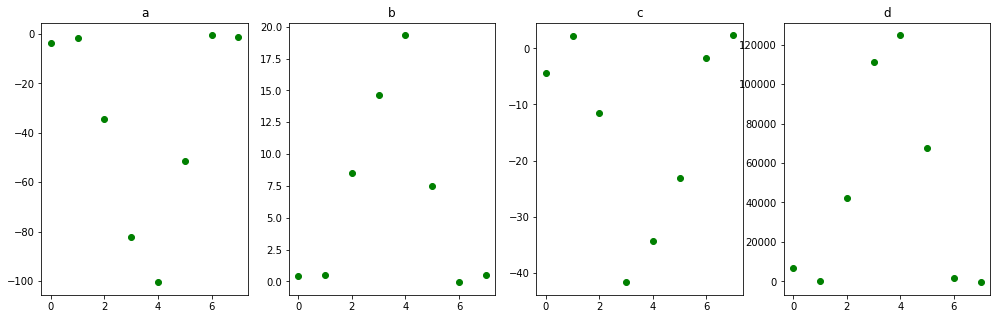

In [3]:
nums = 100
points_two_directions = []

for num in range(0,4,2):
    my_sys = triang.triangulation_solution(cameraMatrix)
    img_path1 = data_path + directions[num] + "/frame_env_2_" + directions[num] + "_" + str(num) + ".jpg"
    cord_path1 = data_path + directions[num] + "/meta_env_2_" + directions[num] + "_" + str(num) + ".json"
    img_path2 = data_path + directions[num+1] + "/frame_env_2_" + directions[num+1] + "_" + str(num+1) + ".jpg"
    cord_path2 = data_path + directions[num+1] + "/meta_env_2_" + directions[num+1] + "_" + str(num+1) + ".json"
    
    keypoints_path1 = "Oussama_" + directions[num] + "points.npz"
    keypoints_path2 = "Oussama_" + directions[num+1] + "points.npz"

    points_new = my_sys.triangulate_all_pairs(nums_im = nums, num_keypoits = 11,
                                         cord_path1 = cord_path1, cord_path2 = cord_path2,
                                         keypoints_path1 = keypoints_path1, keypoints_path2 = keypoints_path2,
                                         T_cam2gripper = T_cam2gripper)
    points_two_directions.append(points_new)

points_coord = (points_two_directions[0] + points_two_directions[1])/2
equation_mean = np.zeros(4)

fig, axs = plt.subplots(1, 4, figsize = (17,5))
axs[0].set_title("a")
axs[1].set_title("b")
axs[2].set_title("c")
axs[3].set_title("d")

for i in range(len(points_coord)-3):
    equation = my_sys.equation_plane(points_coord[i], points_coord[i+1], points_coord[i+2])
    axs[0].scatter(i, equation[0], c ='g')
    axs[1].scatter(i, equation[1] ,c ='g')
    axs[2].scatter(i, equation[2] ,c ='g')
    axs[3].scatter(i, equation[3] ,c ='g')
    equation_mean += equation

equation_mean = equation_mean/(len(points_coord)-3)
print(equation_mean)
z_axis = equation_mean[:-1]
equation_mean /= np.linalg.norm(z_axis)
trans_model2base_tria = (points_coord[4] + points_coord[5])/2
x_axis = points_coord[5] - points_coord[4]
x_axis /= np.linalg.norm(x_axis)
y_axis = np.cross(z_axis, x_axis)
R_model2base_tria = np.array([x_axis, y_axis, z_axis]).T
T_model2base_tria = np.concatenate((R_model2base_tria, trans_model2base_tria[None].T), axis = 1)
T_model2base_tria = np.concatenate((T_model2base_tria, [[0, 0, 0, 1]]), axis = 0)



## 2. PnP

In [4]:
for direction in directions:
    print(direction)
    points_path = "Oussama_" + direction + "points.npz"
    for num in range(nums):
        if(num == nums - 1):
            print(num)

        im_path = data_path + direction + "/frame_env_2_" + direction + "_" + str(num) + ".jpg"
        cord_path = data_path + direction + "/meta_env_2_" + direction + "_" + str(num) + ".json"
        
        my_sys = pnp.pnp_solution(NUM_KEYPOINTS = 19, mtx = cameraMatrix, dist = distCoeffs, 
                              im_path = im_path, cord_path = cord_path)
        
        img = cv2.imread(my_sys.img_path)
        points = my_sys.predict_socket_points(points_path)[num]
        im_points = np.concatenate((points[2:6, :], points[7:9, :], points[10:15, :]), axis=0)
        im_points = np.array(im_points, dtype=np.float32)
        object_points = my_sys.real_coordinate()
        object_points = np.concatenate((object_points[2:6,:], object_points[7:9,:],object_points[10:15,:]), axis=0)

        retval, rot_vec, trans_vec = cv2.solvePnP(objectPoints=object_points,
                                                  imagePoints=im_points,
                                                  distCoeffs=my_sys.dist,
                                                  cameraMatrix=my_sys.mtx)
        
#         retval, rot_vec, trans_vec = my_sys.solvepnp_problem(objectPoints=object_points,
#                                                              imagePoints=im_points)
        
        R_model2cam = R.from_rotvec(rot_vec.T[0]).as_matrix()
        T_model2cam = np.concatenate((R_model2cam, trans_vec), axis=1)
        T_model2cam = np.concatenate((T_model2cam,[[0,0,0,1]]), axis=0)
    
        with open(my_sys.cord_path) as json_file:
            json_data = json.load(json_file)
            R_gripper2base = R.from_rotvec(np.array(json_data['l'][3:])).as_matrix()
            trans_gripper2base = np.array(json_data['l'][:3])*1000
            
        T_gripper2base = np.concatenate((R_gripper2base, trans_gripper2base[None].T), axis = 1)
        T_gripper2base = np.concatenate((T_gripper2base, [[0,0,0,1]]), axis = 0)
        T_model2base = T_gripper2base @ T_cam2gripper @ T_model2cam

        R_model2base = T_model2base[0:3,0:3]
        trans_model2base = T_model2base[:-1, -1]
        R_quat = R.from_matrix(R_model2base).as_quat()
        quat_all_pnp = np.concatenate((quat_all_pnp, R_quat[None]), axis = 0)
        trans_all_pnp = np.concatenate((trans_all_pnp, trans_model2base[None]), axis = 0)

quat_all_pnp = quat_all_pnp[1:]
trans_all_pnp = trans_all_pnp[1:]

up
99
down
99
left
99
right
99


[1000.85744133  -57.02859108  690.4862228 ]
[[-0.02377479  0.0344708  -0.99912288]
 [-0.99887838  0.04011609  0.02515302]
 [ 0.04094794  0.99860025  0.03347838]]
4.252804751574788  mm


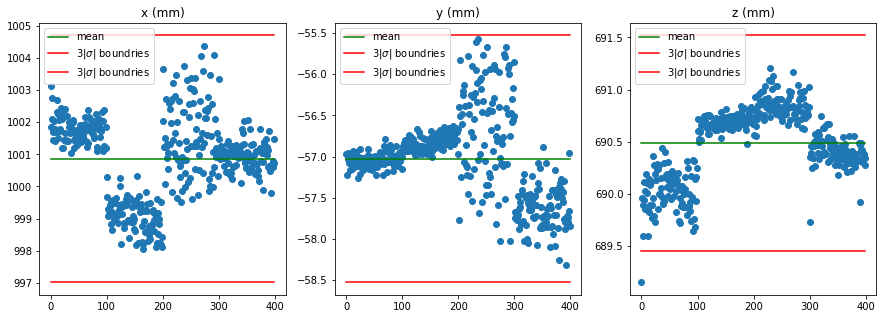

In [5]:
quat_up = quat_all_pnp[:nums]
quat_down = quat_all_pnp[nums:2*nums]
quat_left = quat_all_pnp[2*nums:3*nums]
quat_right = quat_all_pnp[3*nums:4*nums]

rot_up = stat.rotation_statistics(quat_up)
rot_down = stat.rotation_statistics(quat_down)
rot_right = stat.rotation_statistics(quat_left)
rot_left = stat.rotation_statistics(quat_right)

translations_up = trans_all_pnp[:num]
translations_down = trans_all_pnp[num:2*num]
translations_left = trans_all_pnp[2*num:3*num]
translations_right = trans_all_pnp[3*num:4*num]

trans_up = stat.trans_statistics(translations_up)
trans_down = stat.trans_statistics(translations_down)
trans_right = stat.trans_statistics(translations_left)
trans_left = stat.trans_statistics(translations_right)

angle_error_up = rot_up.angle_error()
angle_error_down = rot_down.angle_error()
angle_error_left = rot_left.angle_error()
angle_error_right = rot_right.angle_error()

trans_error_up = trans_up.translation_error()
trans_error_down = trans_down.translation_error()
trans_error_left = trans_left.translation_error()
trans_error_right = trans_right.translation_error()

rot_all = stat.rotation_statistics(quat_all_pnp)
angle_error_all = rot_all.angle_error()
R_model2base_pnp = rot_all.rot_mean.as_matrix()

trans_all = stat.trans_statistics(trans_all_pnp)
trans_error_all = trans_all.translation_error()
trans_model2base_pnp = np.array([trans_all.x_mean, trans_all.y_mean, trans_all.z_mean])
print(trans_model2base_pnp)
print(R_model2base_pnp)

# print(np.rad2deg(angle_error_up), " degrees")
# print(np.rad2deg(angle_error_down)," degrees")
# print(np.rad2deg(angle_error_left), " degrees")
# print(np.rad2deg(angle_error_right), " degrees")
# print(np.rad2deg(angle_error_all), " degrees")

# print("")

# print(trans_error_up, " mm")
# print(trans_error_down, " mm")
# print(trans_error_left, " mm")
# print(trans_error_right, " mm")
print(trans_error_all, " mm")

# print(trans_error_all, " mm")

# rot_up.draw_stat(['yaw', "pitch", 'roll'])
# rot_down.draw_stat(['yaw', "pitch", 'roll'])
# rot_left.draw_stat(['yaw', "pitch", 'roll'])
# rot_right.draw_stat(['yaw', "pitch", 'roll'])
# rot_all.draw_stat(['yaw (degrees)', "pitch (degrees)", 'roll (degrees)'], degrees = True)

# plt.hist(quat_up[:,0])
plt.show()
# trans_up.draw_stat('xyz')
# trans_down.draw_stat('xyz')
# trans_left.draw_stat('xyz')
# trans_right.draw_stat('xyz')
trans_all.draw_stat(['x (mm)', 'y (mm)', 'z (mm)'])

## 3. Comparision

In [17]:
rot_error_pnp_tria = R_model2base_tria@(R_model2base_pnp.T)
print(rot_error_pnp_tria)
trans_error_pnp_tria = trans_model2base_tria - trans_model2base_pnp
print(trans_error_pnp_tria)
print(np.linalg.norm(trans_error_pnp_tria))
angle_error_pnp_tria = np.linalg.norm((R.from_matrix(rot_error_pnp_tria)).as_rotvec())
angle_error_pnp_tria = np.rad2deg(angle_error_pnp_tria)
print(angle_error_pnp_tria)

[[ 0.90463192  0.17803843 -0.3872591 ]
 [-0.14149399  0.98250257  0.12102085]
 [ 0.40202451 -0.05465952  0.91399372]]
[-9.69144993  4.44455034  5.85198585]
12.162399756624211
25.767618646733617


\begin{equation}
trans_{error} = 
\begin{bmatrix}
-9.70 & 4.44 & 5.86\\
\end{bmatrix}
mm
\end{equation}

$$||trans_{error}||_2 = 12.16 mm$$

\begin{equation}
R_{error} = 
\begin{bmatrix}
0.90463192 & 0.17803843 &-0.3872591 \\
-0.14149399 & 0.98250257 & 0.12102085\\
 0.40202451 &-0.05465952 & 0.91399372\\
\end{bmatrix}
\end{equation}

$$|angle_{error}| = 25.77 degrees$$

$$ ax+by+cz+d=0 $$

$$a= -34.4190745 $$
$$b = 6.41861981$$
$$c = -14.0512479 $$
$$d = 4.42342774 * 10^{4}$$
$$std_{trans} = 1.42  mm$$

In [24]:
4.25/3

1.4166666666666667